### Import libraries

In [48]:
# import statements
%load_ext autoreload
%load_ext jupyternotify
%autoreload 2
%cd "../../"

import torch 
from torch.autograd import Variable 
import torch.nn as nn
import torch.optim as optim

import warnings
warnings.filterwarnings('ignore')
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    

import numpy as np
import time

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import pickle
from scipy.cluster.vq import kmeans2
import scipy.stats as ss
from scipy.io import loadmat

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>

/m/home/home5/56


### Generate data

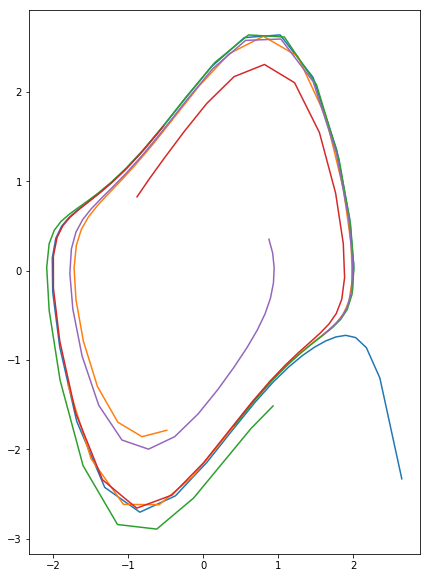

In [49]:
# generate data
use_gpu = 1

class VDP(torch.nn.Module):
    def forward(self, t, x):
        return torch.cat([x[:,1:2], (1-x[:,0:1]**2)*x[:,1:2]-x[:,0:1]],1)

# from torchdiffeq import odeint_adjoint as odeint
from torchdiffeq import odeint

device = torch.device('cuda:' + str(use_gpu) if torch.cuda.is_available() else 'cpu')

N = 5
R = 3

x0 = torch.from_numpy(2*R*ss.uniform.rvs(size=[N,2])-R)
t = torch.linspace(0., 7., 40)

with torch.no_grad():
    X = odeint(VDP(), x0, t, method='rk4').numpy()
    X = np.transpose(X,[1,0,2])
    Y = X + ss.norm.rvs(size=X.shape)*0.1
    
plt.figure(1,[7,10])
for i in range(X.shape[0]):
    plt.plot(X[i,:,0],X[i,:,1],'-')

## Implementation-1, gradients computed via sensitivities (uses autograd as a subroutine) 

### Initialize the model, parameters, variables, etc

In [ ]:
# create variables, functions etc
M   = 6 # MxM inducing grid
D   = 2
sf  = 1
ell = 0.75

torch.set_default_tensor_type(torch.DoubleTensor)
xv = np.linspace(np.min([np.min(Y_[:,0]) for Y_ in Y]), np.max([np.max(Y_[:,0]) for Y_ in Y]), M)
yv = np.linspace(np.min([np.min(Y_[:,1]) for Y_ in Y]), np.max([np.max(Y_[:,1]) for Y_ in Y]), M)
xv,yv = np.meshgrid(xv,yv)
Z  = np.array([xv.T.flatten(),yv.T.flatten()]).T
Zt = torch.from_numpy(Z)
Yt = torch.from_numpy(Y)
U0 = 0.1*torch.randn(M*M, D)
# U0 = VDP().forward(0,Zt)

def _flatten(sequence):
    flat = [p.contiguous().view(-1) for p in sequence]
    return torch.cat(flat) if len(flat) > 0 else torch.tensor([])

def sq_dist(X1,X2):
    X1 = X1 / ell
    X1s = torch.sum(X1**2, dim=1).view([-1,1]) 
    X2 = X2 / ell
    X2s = torch.sum(X2**2, dim=1).view([1,-1])
    return -2*torch.mm(X1,torch.t(X2)) + X1s + X2s

def K(X1,X2):
    dist = sq_dist(X1,X2)
    return sf**2 * torch.exp(-dist / 2)

# gradient matching
F_ = (Yt[:,1:,:]-Yt[:,:-1,:]) / (t[1]-t[0])
F_ = F_.contiguous().view(-1,D)
Z_ = Yt[:,:-1,:].contiguous().view(-1,D)
Kxz = K(Zt,Z_)
Kzzinv = (K(Z_,Z_)+0.2*torch.eye(Z_.shape[0])).inverse()
U0 = torch.mm(torch.mm(Kxz,Kzzinv),F_) # not whitened
Linv = torch.cholesky(K(Zt,Zt)).inverse()
U0 = torch.mm(Linv,U0) # whitened

class KernelRegression(torch.nn.Module):
    def __init__(self):
        super(KernelRegression, self).__init__()
        self.U = torch.nn.Parameter(U0, requires_grad=True)
        self.Z = Zt
        self.Kzz = K(Zt,Zt)
        self.Kzzinv = self.Kzz.inverse()
        self.L = torch.cholesky(self.Kzz)
        self.KzzinvL = torch.mm(self.Kzzinv,self.L)

    def forward(self, t, X):
        T = torch.mm(K(X,self.Z),self.KzzinvL)
        return torch.mm(T,self.U)

class ODEINT_FS(torch.autograd.Function):
    @staticmethod
    def forward(ctx, func, x0, t, th):
        xode = odeint(func, x0, t, method='rk4').permute([1,0,2])
        ctx.func = func
        ctx.save_for_backward(x0,t,th,xode)
        return xode # N,T,D
    @staticmethod
    def backward(ctx, *grad_output): # grad_output[0] N,T,D ---> dL/dxode
        # print('backward')
        func = ctx.func
        x0,t,th,xode = ctx.saved_tensors
        N = x0.shape[0]  # problem dimensionality
        D = x0.shape[1]  # problem dimensionality
        MD = torch.numel(th) # number of parameters in the differential function
        with torch.no_grad():
            def ode_sens_rhs(t,xS): # xS = N,D,(1+MD)
                x = xS[:,:,0].view(-1,D) # N,D
                S = xS[:,:,1:] # N,D,MD
                th = list(func.parameters())[0]
                dxs = []
                dSs = []
                for j in range(N):
                    x_ = x[j:j+1].requires_grad_(True) #.detach() # 1,D
                    S_ = S[j] # D,MD
                    J = [] # accumulate columns of J here
                    R = [] # accumulate columns of R here
                    for i in range(D): # partial derivative of output dimension i 
                        with torch.set_grad_enabled(True):
                            f = func(t,x_)[0,i]
                            dfdxth = torch.autograd.grad(f, [x_,th], allow_unused=False, retain_graph=False)
                            J.append(dfdxth[0])
                            R.append(dfdxth[1].view(1,-1)) # 1,MD
                    J = torch.cat(J) # D,D
                    R = torch.cat(R) # D,MD
                    dS = torch.matmul(J,S_)+R # D,MD
                    dx = func(t,x_) # 1,D
                    dxs.append(dx.unsqueeze(2)) # 1,D,1
                    dSs.append(dS.unsqueeze(0)) # 1,D,MD
                dx = torch.cat(dxs) # N,D,1
                dS = torch.cat(dSs) # N,D,MD
                dxdS = torch.cat([dx,dS],2)
                return dxdS
            x0 = torch.unsqueeze(x0,2) # N,D,1
            S0 = torch.zeros(N,D,MD)
            xS0 = torch.cat((x0,S0),2) # N,D,(1+MD)
            xS = odeint(ode_sens_rhs, xS0, t, method='rk4') # T,N,D,(1+MD)
            xode2 = xS[:,:,:,0].permute([1,0,2]) # N,T,D
            # print('error between two ode integrations is {:f}'.format(torch.abs(xode-xode2).sum().numpy()))
            S = xS[:,:,:,1:].permute([1,2,0,3]) # N,D,T,MD
            # print(grad_output[0].shape) # N,T,D
            dlossdx = grad_output[0].permute([0,2,1]).unsqueeze(3) # N,D,T,1
            dlossdU = torch.sum(S*dlossdx,[0,1,2]) # MD
        return None,None,None,dlossdU # N,T,D
    
odeint_fs = ODEINT_FS.apply
kreg = KernelRegression()

# check why doesn't work
# from torch.autograd import gradcheck
# th_ = _flatten(kreg.parameters())
# test = gradcheck(odeint_fs, [kreg,x0,t,th_], eps=1e-6, atol=1e-4)
# print(test)

def odeint_forw_sens(func, x0, t):
    th = _flatten(func.parameters())
    xode = odeint_fs(kreg, x0, t, th)
    return xode
    

### Optimize

In [ ]:
# optimization

logsn = torch.nn.Parameter(torch.zeros(2), requires_grad=True)
params = [kreg.U,logsn]
optimizer = optim.Adam(params, lr=5e-3)

    
for itr in range(500):
    optimizer.zero_grad()
    T   = min(3+itr//10, len(t))
    t_  = t[:T]
    Yt_ = Yt[:,:T,:]
    xode = odeint_forw_sens(kreg,x0,t_)
    loss = torch.sum((Yt_-xode)**2 / torch.exp(logsn)**2) +  torch.numel(Yt_)*torch.sum(logsn)/D + \
        torch.sum(torch.diag(torch.mm(kreg.U.t(),kreg.U)))/2
    loss.backward()
    optimizer.step()

    if itr % 1 == 0:
        with torch.no_grad():
            xode = odeint_forw_sens(kreg,x0,t)
            loss = torch.sum((Yt-xode)**2 / torch.exp(logsn)**2) +  torch.numel(Yt)*torch.sum(logsn)/D
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))

    # break
    end = time.time()


### Visualize

In [ ]:
# plotting
xode = odeint_forw_sens(kreg, x0, t).detach().numpy()
U = kreg.U.detach().numpy()
Z = Zt.detach().numpy()

cols = ['r','b','g','m','c','k']
plt.figure(1,[7,10])
plt.scatter(Z[:,0],Z[:,1],100, facecolors='none', edgecolors='k')
plt.quiver(Z[:,0],Z[:,1],U[:,0],U[:,1],units='height',width=0.006,color='k')
for i in range(min(6,xode.shape[0])):
    plt.plot(X[i,:,0],X[i,:,1],'o',color=cols[i])
    plt.plot(xode[i,:,0],xode[i,:,1],'-',color=cols[i])

## Implementation-2 that uses Torch autograd, no sensitivities/adjoints 

### Initialize the model, parameters, variables, etc

In [73]:
# create variables, functions etc
M   = 6 # MxM inducing grid
D   = 2
sf  = 1
ell = 0.75

torch.set_default_tensor_type(torch.DoubleTensor)
xv = np.linspace(np.min([np.min(Y_[:,0]) for Y_ in Y]), np.max([np.max(Y_[:,0]) for Y_ in Y]), M)
yv = np.linspace(np.min([np.min(Y_[:,1]) for Y_ in Y]), np.max([np.max(Y_[:,1]) for Y_ in Y]), M)
xv,yv = np.meshgrid(xv,yv)
Z  = np.array([xv.T.flatten(),yv.T.flatten()]).T
Zt = torch.from_numpy(Z)
Xt = torch.from_numpy(X)
U0 = 0.1*torch.randn(M*M, D)
# U0 = VDP().forward(0,Zt)

def sq_dist(X1,X2):
    X1 = X1 / ell
    X1s = torch.sum(X1**2, dim=1).view([-1,1]) 
    X2 = X2 / ell
    X2s = torch.sum(X2**2, dim=1).view([1,-1])
    return -2*torch.mm(X1,torch.t(X2)) + X1s + X2s

def K(X1,X2):
    dist = sq_dist(X1,X2)
    return sf**2 * torch.exp(-dist / 2)

# gradient matching
F_ = (Xt[:,1:,:]-Xt[:,:-1,:]) / (t[1]-t[0])
F_ = F_.contiguous().view(-1,D)
Z_ = Xt[:,:-1,:].contiguous().view(-1,D)
Kxz = K(Zt,Z_)
Kzzinv = (K(Z_,Z_)+0.2*torch.eye(Z_.shape[0])).inverse()
U0 = torch.mm(torch.mm(Kxz,Kzzinv),F_)


class KernelRegression(torch.nn.Module):
    def __init__(self):
        super(KernelRegression, self).__init__()
        self.U = torch.nn.Parameter(U0, requires_grad=True)
        self.logsn = torch.nn.Parameter(torch.zeros(2), requires_grad=True)
        self.Z = Zt

    def forward(self, t, X):
#         Z = self.Z
#         M = Z.shape[0]
#         N = X.shape[0]
#         A_LU = torch.lu(K(Z,Z).view(-1,M,M)) # 1,M,M
#         Kxz  = torch.t(K(X,Z)).view(-1,M,N)  # 1,M,N
#         A = torch.lu_solve(Kxz, *A_LU).view(M,N) # M x N
#         f = torch.mm(torch.t(A),self.U) # N x M
#         return f
#         Z = self.Z
#         Ltinv = torch.t(torch.cholesky(K(Z,Z))).inverse()
#         return torch.mm(torch.mm(K(X,Z),Ltinv),self.U)
        Z = self.Z
        Kzzinv = K(Z,Z).inverse()
        return torch.mm(torch.mm(K(X,Z),Kzzinv),self.U)
    

Kzzinv = K(Zt, Zt).inverse()

npode = KernelRegression()
# lbfgs = optim.LBFGS(npode.parameters(), lr=1e-3)
# optimizer = optim.Adam(npode.parameters(), lr=5e-3)
optimizer = optim.SGD(npode.parameters(), lr=3e-5)


### Optimize

In [80]:
# optimization
def closure():
    optimizer.zero_grad()
    xode = odeint(npode, x0, t).permute([1,0,2])
    loss = torch.mean((Xt-xode)**2 / torch.exp(npode.logsn))
    loss.backward()
    return loss

    
# n_iters = 1000
n_iters = 1000

## learning rate scheduling for sgd+momentum and rmsprop
lr = 5e-4
lr_decay=0.03

## Momentum schedulin for sgd+momentum
mom_init = 0.5
mom_final = 0.99
mom_decay = 0.03

for itr in range(n_iters):
    optimizer.zero_grad()

    for g in optimizer.param_groups:
        g['lr'] = lr/(1+lr_decay*i)
    for g in optimizer.param_groups:
        g['momentum'] = mom_final - (mom_final-mom_init)/(1+mom_decay*i)

    xode = odeint(npode, x0, t, method='rk4').permute([1,0,2])
    loss = torch.sum((Xt-xode)**2 / torch.exp(npode.logsn)**2) +  torch.numel(Xt)*torch.sum(npode.logsn)/D + \
        torch.sum(torch.diag(torch.mm(npode.U.t(), torch.mm(Kzzinv, npode.U))))/2
    loss.backward()
    optimizer.step()
#     lbfgs.step(closure)

    if itr % 1 == 0:
        with torch.no_grad():
            xode = odeint(npode, x0, t, method='rk4').permute([1,0,2])
            if torch.isnan(loss):
                %notify -m "Nan encountered in loss"
                break
            loss = torch.mean((Xt-xode)**2 / torch.exp(npode.logsn))
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))

    end = time.time()

Iter 0000 | Total Loss 0.219714
Iter 0001 | Total Loss 0.181783
Iter 0002 | Total Loss 0.163421
Iter 0003 | Total Loss 0.154092
Iter 0004 | Total Loss 0.148940
Iter 0005 | Total Loss 0.146183
Iter 0006 | Total Loss 0.146257
Iter 0007 | Total Loss 0.150832
Iter 0008 | Total Loss 0.160313
Iter 0009 | Total Loss 0.171137
Iter 0010 | Total Loss 0.177724
Iter 0011 | Total Loss 0.179771
Iter 0012 | Total Loss 0.181611
Iter 0013 | Total Loss 0.182752
Iter 0014 | Total Loss 0.184655
Iter 0015 | Total Loss 0.187182
Iter 0016 | Total Loss 0.188879
Iter 0017 | Total Loss 0.188544
Iter 0018 | Total Loss 0.186335
Iter 0019 | Total Loss 0.187740
Iter 0020 | Total Loss 0.215176
Iter 0021 | Total Loss 0.609429
Iter 0022 | Total Loss 2.261519
Iter 0023 | Total Loss 0.382283
Iter 0024 | Total Loss 0.499641
Iter 0025 | Total Loss 0.471299
Iter 0026 | Total Loss 0.432908
Iter 0027 | Total Loss 0.404752
Iter 0028 | Total Loss 0.386519
Iter 0029 | Total Loss 0.374708
Iter 0030 | Total Loss 0.365872
Iter 003

Iter 0258 | Total Loss 1.076222
Iter 0259 | Total Loss 0.593739
Iter 0260 | Total Loss 0.405640
Iter 0261 | Total Loss 0.328496
Iter 0262 | Total Loss 0.297152
Iter 0263 | Total Loss 0.286424
Iter 0264 | Total Loss 0.284330
Iter 0265 | Total Loss 0.283740
Iter 0266 | Total Loss 0.279954
Iter 0267 | Total Loss 0.270594
Iter 0268 | Total Loss 0.256439
Iter 0269 | Total Loss 0.241796
Iter 0270 | Total Loss 0.233047
Iter 0271 | Total Loss 0.234314
Iter 0272 | Total Loss 0.242666
Iter 0273 | Total Loss 0.248981
Iter 0274 | Total Loss 0.247042
Iter 0275 | Total Loss 0.239637
Iter 0276 | Total Loss 0.232867
Iter 0277 | Total Loss 0.230328
Iter 0278 | Total Loss 0.230491
Iter 0279 | Total Loss 0.227510
Iter 0280 | Total Loss 0.223757
Iter 0281 | Total Loss 0.221185
Iter 0282 | Total Loss 0.217864
Iter 0283 | Total Loss 0.213301
Iter 0284 | Total Loss 0.208832
Iter 0285 | Total Loss 0.204235
Iter 0286 | Total Loss 0.199618
Iter 0287 | Total Loss 0.195734
Iter 0288 | Total Loss 0.192124
Iter 028

Iter 0516 | Total Loss 0.213576
Iter 0517 | Total Loss 0.208936
Iter 0518 | Total Loss 0.204623
Iter 0519 | Total Loss 0.200662
Iter 0520 | Total Loss 0.197067
Iter 0521 | Total Loss 0.193839
Iter 0522 | Total Loss 0.190944
Iter 0523 | Total Loss 0.188345
Iter 0524 | Total Loss 0.185993
Iter 0525 | Total Loss 0.183839
Iter 0526 | Total Loss 0.181838
Iter 0527 | Total Loss 0.179951
Iter 0528 | Total Loss 0.178151
Iter 0529 | Total Loss 0.176411
Iter 0530 | Total Loss 0.174729
Iter 0531 | Total Loss 0.173071
Iter 0532 | Total Loss 0.171497
Iter 0533 | Total Loss 0.169865
Iter 0534 | Total Loss 0.168640
Iter 0535 | Total Loss 0.167468
Iter 0536 | Total Loss 0.177291
Iter 0537 | Total Loss 0.275369
Iter 0538 | Total Loss 1.261455
Iter 0539 | Total Loss 1.995214
Iter 0540 | Total Loss 1.199850
Iter 0541 | Total Loss 0.722862
Iter 0542 | Total Loss 0.532441
Iter 0543 | Total Loss 0.458015
Iter 0544 | Total Loss 0.434400
Iter 0545 | Total Loss 0.434861
Iter 0546 | Total Loss 0.445521
Iter 054

Iter 0774 | Total Loss 0.122137
Iter 0775 | Total Loss 0.110545
Iter 0776 | Total Loss 0.120394
Iter 0777 | Total Loss 0.134462
Iter 0778 | Total Loss 0.141564
Iter 0779 | Total Loss 0.149991
Iter 0780 | Total Loss 0.160721
Iter 0781 | Total Loss 0.165379
Iter 0782 | Total Loss 0.169160
Iter 0783 | Total Loss 0.170949
Iter 0784 | Total Loss 0.169899
Iter 0785 | Total Loss 0.168073
Iter 0786 | Total Loss 0.165656
Iter 0787 | Total Loss 0.162048
Iter 0788 | Total Loss 0.160948
Iter 0789 | Total Loss 0.162141
Iter 0790 | Total Loss 0.215577
Iter 0791 | Total Loss 0.580503
Iter 0792 | Total Loss 1.689584
Iter 0793 | Total Loss 0.087212
Iter 0794 | Total Loss 0.244215
Iter 0795 | Total Loss 0.301165
Iter 0796 | Total Loss 0.296814
Iter 0797 | Total Loss 0.266440
Iter 0798 | Total Loss 0.224161
Iter 0799 | Total Loss 0.178333
Iter 0800 | Total Loss 0.137863
Iter 0801 | Total Loss 0.113166
Iter 0802 | Total Loss 0.110751
Iter 0803 | Total Loss 0.124210
Iter 0804 | Total Loss 0.136589
Iter 080

### Visualize

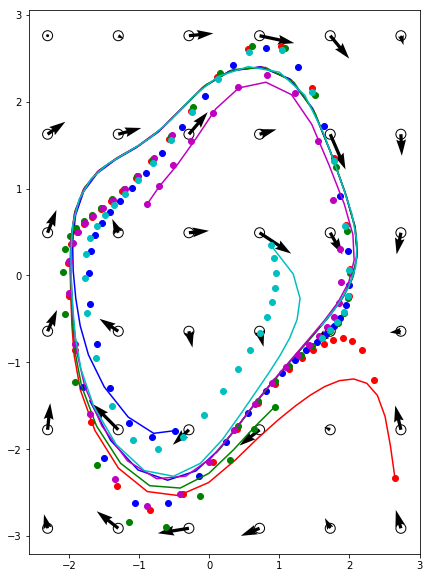

In [81]:
# plotting
xode = odeint(npode, x0, t).detach().numpy()
U = npode.U.detach().numpy()
Z = npode.Z.detach().numpy()
xode = np.transpose(xode,[1,0,2])

cols = ['r','b','g','m','c','k']
plt.figure(1,[7,10])
plt.scatter(Z[:,0],Z[:,1],100, facecolors='none', edgecolors='k')
plt.quiver(Z[:,0],Z[:,1],U[:,0],U[:,1],units='height',width=0.006,color='k')
for i in range(min(6,xode.shape[0])):
    plt.plot(X[i,:,0],X[i,:,1],'o',color=cols[i])
    plt.plot(xode[i,:,0],xode[i,:,1],'-',color=cols[i])

## Old stuff

In [ ]:
# working
M   = 6 # MxM inducing grid
D   = 2
sf  = 1
ell = 0.75

torch.set_default_tensor_type(torch.DoubleTensor)
xv = np.linspace(np.min([np.min(Y_[:,0]) for Y_ in Y]), np.max([np.max(Y_[:,0]) for Y_ in Y]), M)
yv = np.linspace(np.min([np.min(Y_[:,1]) for Y_ in Y]), np.max([np.max(Y_[:,1]) for Y_ in Y]), M)
xv,yv = np.meshgrid(xv,yv)
Z  = np.array([xv.T.flatten(),yv.T.flatten()]).T
Zt = torch.from_numpy(Z)
Yt = torch.from_numpy(Y)
U0 = 0.1*torch.randn(M*M, D)
# U0 = VDP().forward(0,Zt)

def _flatten(sequence):
    flat = [p.contiguous().view(-1) for p in sequence]
    return torch.cat(flat) if len(flat) > 0 else torch.tensor([])

def sq_dist(X1,X2):
    X1 = X1 / ell
    X1s = torch.sum(X1**2, dim=1).view([-1,1]) 
    X2 = X2 / ell
    X2s = torch.sum(X2**2, dim=1).view([1,-1])
    return -2*torch.mm(X1,torch.t(X2)) + X1s + X2s

def K(X1,X2):
    dist = sq_dist(X1,X2)
    return sf**2 * torch.exp(-dist / 2)

# gradient matching
# F_ = (Yt[:,1:,:]-Yt[:,:-1,:]) / (t[1]-t[0])
# F_ = F_.contiguous().view(-1,D)
# Z_ = Yt[:,:-1,:].contiguous().view(-1,D)
# Kxz = K(Zt,Z_)
# Kzzinv = (K(Z_,Z_)+0.2*torch.eye(Z_.shape[0])).inverse()
# U0 = torch.mm(torch.mm(Kxz,Kzzinv),F_) # not whitened
# Linv = torch.cholesky(K(Zt,Zt)).inverse()
# U0 = torch.mm(Linv,U0) # whitened

class KernelRegression(torch.nn.Module):
    def __init__(self):
        super(KernelRegression, self).__init__()
        self.U = torch.nn.Parameter(U0, requires_grad=True)
        self.Z = Zt
        self.Kzz = K(Zt,Zt)
        self.Kzzinv = self.Kzz.inverse()
        self.L = torch.cholesky(self.Kzz)
        self.KzzinvL = torch.mm(self.Kzzinv,self.L)

    def forward(self, t, X):
        T = torch.mm(K(X,self.Z),self.KzzinvL)
        return torch.mm(T,self.U)

class ODEINT_FS(torch.autograd.Function):
    @staticmethod
    def forward(ctx, func, x0, t, th):
        xode = odeint(func, x0, t, method='rk4').permute([1,0,2])
        ctx.func = func
        ctx.save_for_backward(x0,t,th,xode)
        return xode # N,T,D
    @staticmethod
    def backward(ctx, *grad_output): # grad_output[0] N,T,D ---> dL/dxode
        # print('backward')
        func = ctx.func
        x0,t,th,xode = ctx.saved_tensors
        D = x0.shape[1]  # problem dimensionality
        MD = torch.numel(th) # number of parameters in the differential function
        with torch.no_grad():
            def ode_sens_rhs(t,xS):
                x = xS[0:D].view(-1,D).detach().requires_grad_(True)
                S = xS[D:].view(D,MD)
                th = list(func.parameters())[0]
                J = [] # accumulate columns of J here
                R = [] # accumulate columns of R here
                for i in range(D): # partial derivative of output dimension i 
                    with torch.set_grad_enabled(True):
                        f = func(t,x)[0,i]
                        dfdxth = torch.autograd.grad(f, [x,th], allow_unused=False, retain_graph=False)
                        J.append(dfdxth[0])
                        R.append(dfdxth[1])
                J = torch.cat(J)  # D,D
                R = torch.cat([r.view(1,-1) for r in R]) # D,MD
                dS = torch.matmul(J,S)+R
                dx = func(t,x)[0]
                dxdS = torch.cat((dx.view(-1),dS.view(-1)))
                return dxdS
            S0 = torch.zeros(D,MD)
            xS0 = torch.cat((x0.view(-1),S0.view(-1)),0)
            xS = odeint(ode_sens_rhs, xS0, t, method='rk4') # T,1,(D+DMD)
            xode2 = xS[:,0:2].unsqueeze(0) # 1,T,D
            # print('error between two ode integrations is {:f}'.format(torch.abs(xode-xode2).sum().numpy()))
            S = xS[:,2:].t().view(D,MD,-1).permute([0,2,1]) # D,T,MD
            dlossdx = grad_output[0][0].t().unsqueeze(2) # D,T,1
            dlossdU = torch.sum(S*dlossdx,[0,1]) # MD
        return None,None,None,dlossdU # N,T,D
    
odeint_fs = ODEINT_FS.apply
kreg = KernelRegression()

# check why doesn't work
# from torch.autograd import gradcheck
# th_ = _flatten(kreg.parameters())
# test = gradcheck(odeint_fs, [kreg,x0,t,th_], eps=1e-6, atol=1e-4)
# print(test)

def odeint_forw_sens(func, x0, t):
    th = _flatten(func.parameters())
    xode = odeint_fs(kreg, x0, t, th)
    return xode
    
logsn = torch.nn.Parameter(torch.zeros(2), requires_grad=True)
params = [kreg.U,logsn]
optimizer = optim.Adam(params, lr=5e-3)
    
for itr in range(500):
    optimizer.zero_grad()
    xode = odeint_forw_sens(kreg,x0,t)
    loss = torch.sum((Yt-xode)**2 / torch.exp(logsn)**2) +  torch.numel(Yt)*torch.sum(logsn)/D
    loss.backward()
    optimizer.step()

    if itr % 1 == 0:
        with torch.no_grad():
            xode = odeint_forw_sens(kreg,x0,t)
            loss = torch.sum((Yt-xode)**2 / torch.exp(logsn)**2) +  torch.numel(Yt)*torch.sum(logsn)/D
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))

    # break
    end = time.time()


## Inference using MCMC

### Initialize Model and params

In [36]:

# create variables, functions etc
M   = 6 # MxM inducing grid
D   = 2
sf  = 1
ell = 0.75

torch.set_default_tensor_type(torch.DoubleTensor)
xv = np.linspace(np.min([np.min(Y_[:,0]) for Y_ in Y]), np.max([np.max(Y_[:,0]) for Y_ in Y]), M)
yv = np.linspace(np.min([np.min(Y_[:,1]) for Y_ in Y]), np.max([np.max(Y_[:,1]) for Y_ in Y]), M)
xv,yv = np.meshgrid(xv,yv)
Z  = np.array([xv.T.flatten(),yv.T.flatten()]).T
Zt = torch.from_numpy(Z)
Xt = torch.from_numpy(X)
U0 = 0.1*torch.randn(M*M, D)
# U0 = VDP().forward(0,Zt)

def sq_dist(X1,X2):
    X1 = X1 / ell
    X1s = torch.sum(X1**2, dim=1).view([-1,1]) 
    X2 = X2 / ell
    X2s = torch.sum(X2**2, dim=1).view([1,-1])
    return -2*torch.mm(X1,torch.t(X2)) + X1s + X2s

def K(X1,X2):
    dist = sq_dist(X1,X2)
    return sf**2 * torch.exp(-dist / 2)

# gradient matching
F_ = (Xt[:,1:,:]-Xt[:,:-1,:]) / (t[1]-t[0])
F_ = F_.contiguous().view(-1,D)
Z_ = Xt[:,:-1,:].contiguous().view(-1,D)
Kxz = K(Zt,Z_)
Kzzinv = (K(Z_,Z_)+0.2*torch.eye(Z_.shape[0])).inverse()
U0 = torch.mm(torch.mm(Kxz,Kzzinv),F_)


class KernelRegression(torch.nn.Module):
    def __init__(self):
        super(KernelRegression, self).__init__()
        self.U = torch.nn.Parameter(U0, requires_grad=True)
        self.logsn = torch.nn.Parameter(torch.zeros(2), requires_grad=True)
        self.Z = Zt

    def forward(self, t, X):
#         Z = self.Z
#         M = Z.shape[0]
#         N = X.shape[0]
#         A_LU = torch.lu(K(Z,Z).view(-1,M,M)) # 1,M,M
#         Kxz  = torch.t(K(X,Z)).view(-1,M,N)  # 1,M,N
#         A = torch.lu_solve(Kxz, *A_LU).view(M,N) # M x N
#         f = torch.mm(torch.t(A),self.U) # N x M
#         return f
#         Z = self.Z
#         Ltinv = torch.t(torch.cholesky(K(Z,Z))).inverse()
#         return torch.mm(torch.mm(K(X,Z),Ltinv),self.U)
        Z = self.Z
        Kzzinv = K(Z,Z).inverse()
        return torch.mm(torch.mm(K(X,Z),Kzzinv),self.U)

kreg = KernelRegression()
Kzzinv = K(Zt, Zt).inverse()
# lbfgs = optim.LBFGS(npode.parameters(), lr=5e-3)
# optimizer = optim.Adam(npode.parameters(), lr=5e-3)

### Inference

In [37]:
from samplers.metrics import *


itr = 0

def closure():
    global itr
    T   = min(3+itr//10, len(t))
    itr += 1
    t_  = t[:T]
    Xt_ = Xt[:,:T,:]
    xode = odeint(kreg, x0, t_, method='rk4').permute([1,0,2])
    loss = torch.sum((Xt_-xode)**2 / torch.exp(kreg.logsn)**2) +  torch.numel(Xt_)*torch.sum(kreg.logsn)/D + \
        torch.sum(torch.diag(torch.mm(kreg.U.t(),torch.mm(Kzzinv, kreg.U))))/2
    return loss

def psgld_closure(add_prior=True):
    global itr
#     T   = min(3+itr//10, len(t))
    T   = len(t)
    itr += 1
    t_  = t[:T]
    Xt_ = Xt[:,:T,:]
    xode = odeint(kreg, x0, t_, method='rk4').permute([1,0,2])
    loss = torch.sum((Xt_-xode)**2 / torch.exp(kreg.logsn)**2) +  torch.numel(Xt_)*torch.sum(kreg.logsn)/D
    if add_prior:
        loss += torch.sum(torch.diag(torch.mm(kreg.U.t(),torch.mm(Kzzinv, kreg.U))))/2
    return loss/N

def hess_closure():
    hess = eval_full_hessian(torch.autograd.grad(closure(), params, create_graph=True), params)
#     plt.figure()
#     plt.imshow(hess.clone().detach().numpy())
#     plt.colorbar()
    return hess


logsn = torch.nn.Parameter(torch.zeros(2), requires_grad=True)
# params = kreg.parameters()
params = [kreg.U]
# sampler = MALA(params, lr=0.0001, add_noise=False)


#### Computimng size of full hessian #####
# cnt = 0
# loss_grad = torch.autograd.grad(closure(), params)
# for g in loss_grad:
#     g_vector = g.contiguous().view(-1) if cnt == 0\
#                 else torch.cat([g_vector, g.contiguous().view(-1)])
#     cnt = 1
# l = g_vector.size(0)
#########################################

# metric = SoftAbsMetric(closure=hess_closure, softabs_coeff=10)
# metric = HessianMetric(closure=hess_closure)
# metric = IdentityMetric(size=l)


In [38]:
from samplers import MALA, SGLD, MMALA, pSGLD

# sampler = MMALA(params, metric_obj=metric, lr=1e-4)
# sampler = MALA(params, lr=1e-4, add_noise=True)
# sampler = SGLD(params, lr0=0.0001, gamma=0.55, t0=100, alpha=0.1)


# chain, logp_array = sampler.sample(closure, burn_in=2000, num_samples=1000)

sampler = pSGLD(params, lr0=0.003, lr_gamma=0.55, lr_t0=100, lr_alpha=0.3, lambda_=1e-5, alpha=0.99)
chain, logp_array = sampler.sample(psgld_closure, burn_in=4000, num_samples=2000, print_loss=True)


<class 'dict'>
Burn-in phase started
Burn-in iter 0001 | loss 13.375147
Burn-in iter 0002 | loss 14.170524
Burn-in iter 0003 | loss 15.657315
Burn-in iter 0004 | loss 16.485588
Burn-in iter 0005 | loss 16.189258
Burn-in iter 0006 | loss 16.101324
Burn-in iter 0007 | loss 16.023117
Burn-in iter 0008 | loss 16.921830
Burn-in iter 0009 | loss 16.804781
Burn-in iter 0010 | loss 17.115540
Burn-in iter 0011 | loss 16.686812
Burn-in iter 0012 | loss 16.985971
Burn-in iter 0013 | loss 17.687162
Burn-in iter 0014 | loss 17.073482
Burn-in iter 0015 | loss 18.178718
Burn-in iter 0016 | loss 17.414819
Burn-in iter 0017 | loss 17.251714
Burn-in iter 0018 | loss 16.964022
Burn-in iter 0019 | loss 16.335516
Burn-in iter 0020 | loss 16.079104
Burn-in iter 0021 | loss 15.622569
Burn-in iter 0022 | loss 15.498929
Burn-in iter 0023 | loss 16.007042
Burn-in iter 0024 | loss 16.352382
Burn-in iter 0025 | loss 16.489365
Burn-in iter 0026 | loss 16.823346
Burn-in iter 0027 | loss 17.932155
Burn-in iter 0028 

Burn-in iter 0236 | loss 15.733269
Burn-in iter 0237 | loss 15.797446
Burn-in iter 0238 | loss 15.563846
Burn-in iter 0239 | loss 15.638865
Burn-in iter 0240 | loss 15.552750
Burn-in iter 0241 | loss 15.412680
Burn-in iter 0242 | loss 15.791095
Burn-in iter 0243 | loss 15.635304
Burn-in iter 0244 | loss 15.456243
Burn-in iter 0245 | loss 15.782440
Burn-in iter 0246 | loss 15.892719
Burn-in iter 0247 | loss 15.892432
Burn-in iter 0248 | loss 15.555127
Burn-in iter 0249 | loss 15.430335
Burn-in iter 0250 | loss 15.514995
Burn-in iter 0251 | loss 15.887028
Burn-in iter 0252 | loss 15.704483
Burn-in iter 0253 | loss 15.474967
Burn-in iter 0254 | loss 15.941117
Burn-in iter 0255 | loss 15.735750
Burn-in iter 0256 | loss 15.440412
Burn-in iter 0257 | loss 15.413254
Burn-in iter 0258 | loss 15.321756
Burn-in iter 0259 | loss 15.608830
Burn-in iter 0260 | loss 15.312154
Burn-in iter 0261 | loss 15.360429
Burn-in iter 0262 | loss 15.096721
Burn-in iter 0263 | loss 14.558252
Burn-in iter 0264 | 

Burn-in iter 0472 | loss 13.115849
Burn-in iter 0473 | loss 13.483778
Burn-in iter 0474 | loss 13.357058
Burn-in iter 0475 | loss 13.395115
Burn-in iter 0476 | loss 13.660033
Burn-in iter 0477 | loss 13.711549
Burn-in iter 0478 | loss 13.674754
Burn-in iter 0479 | loss 13.553187
Burn-in iter 0480 | loss 13.198216
Burn-in iter 0481 | loss 13.493448
Burn-in iter 0482 | loss 13.978373
Burn-in iter 0483 | loss 14.378725
Burn-in iter 0484 | loss 14.551923
Burn-in iter 0485 | loss 14.765266
Burn-in iter 0486 | loss 14.856951
Burn-in iter 0487 | loss 15.093458
Burn-in iter 0488 | loss 15.107023
Burn-in iter 0489 | loss 14.927809
Burn-in iter 0490 | loss 14.986380
Burn-in iter 0491 | loss 15.242245
Burn-in iter 0492 | loss 15.299012
Burn-in iter 0493 | loss 15.135826
Burn-in iter 0494 | loss 14.899585
Burn-in iter 0495 | loss 15.097094
Burn-in iter 0496 | loss 15.170192
Burn-in iter 0497 | loss 15.010016
Burn-in iter 0498 | loss 14.773882
Burn-in iter 0499 | loss 14.973172
Burn-in iter 0500 | 

Burn-in iter 0708 | loss 16.536224
Burn-in iter 0709 | loss 16.679030
Burn-in iter 0710 | loss 16.081228
Burn-in iter 0711 | loss 16.138311
Burn-in iter 0712 | loss 15.562124
Burn-in iter 0713 | loss 15.343035
Burn-in iter 0714 | loss 15.363897
Burn-in iter 0715 | loss 15.224544
Burn-in iter 0716 | loss 15.151193
Burn-in iter 0717 | loss 15.036537
Burn-in iter 0718 | loss 14.742865
Burn-in iter 0719 | loss 14.697090
Burn-in iter 0720 | loss 14.304595
Burn-in iter 0721 | loss 14.185960
Burn-in iter 0722 | loss 14.087365
Burn-in iter 0723 | loss 13.843753
Burn-in iter 0724 | loss 14.026628
Burn-in iter 0725 | loss 14.075889
Burn-in iter 0726 | loss 13.918926
Burn-in iter 0727 | loss 13.699564
Burn-in iter 0728 | loss 13.770005
Burn-in iter 0729 | loss 13.872744
Burn-in iter 0730 | loss 13.516406
Burn-in iter 0731 | loss 13.736865
Burn-in iter 0732 | loss 13.575894
Burn-in iter 0733 | loss 13.691189
Burn-in iter 0734 | loss 13.570597
Burn-in iter 0735 | loss 13.774148
Burn-in iter 0736 | 

Burn-in iter 0944 | loss 13.420621
Burn-in iter 0945 | loss 13.464353
Burn-in iter 0946 | loss 12.902987
Burn-in iter 0947 | loss 12.837172
Burn-in iter 0948 | loss 13.036202
Burn-in iter 0949 | loss 13.019151
Burn-in iter 0950 | loss 12.524432
Burn-in iter 0951 | loss 12.532840
Burn-in iter 0952 | loss 12.252239
Burn-in iter 0953 | loss 12.314266
Burn-in iter 0954 | loss 12.513423
Burn-in iter 0955 | loss 12.578337
Burn-in iter 0956 | loss 12.325367
Burn-in iter 0957 | loss 12.337056
Burn-in iter 0958 | loss 12.650786
Burn-in iter 0959 | loss 12.261924
Burn-in iter 0960 | loss 12.592234
Burn-in iter 0961 | loss 12.716185
Burn-in iter 0962 | loss 12.772692
Burn-in iter 0963 | loss 12.899868
Burn-in iter 0964 | loss 12.728430
Burn-in iter 0965 | loss 12.676193
Burn-in iter 0966 | loss 12.878236
Burn-in iter 0967 | loss 12.944278
Burn-in iter 0968 | loss 12.908955
Burn-in iter 0969 | loss 12.910797
Burn-in iter 0970 | loss 13.145996
Burn-in iter 0971 | loss 12.857643
Burn-in iter 0972 | 

Burn-in iter 1179 | loss 17.392965
Burn-in iter 1180 | loss 17.209099
Burn-in iter 1181 | loss 17.054797
Burn-in iter 1182 | loss 17.131642
Burn-in iter 1183 | loss 17.143081
Burn-in iter 1184 | loss 16.980782
Burn-in iter 1185 | loss 17.190562
Burn-in iter 1186 | loss 16.703519
Burn-in iter 1187 | loss 16.194144
Burn-in iter 1188 | loss 16.594205
Burn-in iter 1189 | loss 16.847502
Burn-in iter 1190 | loss 16.719357
Burn-in iter 1191 | loss 16.937783
Burn-in iter 1192 | loss 17.175663
Burn-in iter 1193 | loss 17.099275
Burn-in iter 1194 | loss 16.835557
Burn-in iter 1195 | loss 16.741081
Burn-in iter 1196 | loss 16.711305
Burn-in iter 1197 | loss 16.719026
Burn-in iter 1198 | loss 16.606122
Burn-in iter 1199 | loss 16.652959
Burn-in iter 1200 | loss 16.768304
Burn-in iter 1201 | loss 16.770826
Burn-in iter 1202 | loss 17.019495
Burn-in iter 1203 | loss 17.074285
Burn-in iter 1204 | loss 17.194302
Burn-in iter 1205 | loss 17.491510
Burn-in iter 1206 | loss 17.484166
Burn-in iter 1207 | 

Burn-in iter 1415 | loss 18.545712
Burn-in iter 1416 | loss 18.989977
Burn-in iter 1417 | loss 19.288020
Burn-in iter 1418 | loss 19.066227
Burn-in iter 1419 | loss 19.181896
Burn-in iter 1420 | loss 19.087760
Burn-in iter 1421 | loss 18.792698
Burn-in iter 1422 | loss 19.058299
Burn-in iter 1423 | loss 18.697230
Burn-in iter 1424 | loss 18.760960
Burn-in iter 1425 | loss 18.574614
Burn-in iter 1426 | loss 18.493199
Burn-in iter 1427 | loss 18.226813
Burn-in iter 1428 | loss 17.824524
Burn-in iter 1429 | loss 17.720189
Burn-in iter 1430 | loss 17.514567
Burn-in iter 1431 | loss 17.232864
Burn-in iter 1432 | loss 17.025978
Burn-in iter 1433 | loss 17.153422
Burn-in iter 1434 | loss 17.112000
Burn-in iter 1435 | loss 17.149970
Burn-in iter 1436 | loss 17.027479
Burn-in iter 1437 | loss 16.995651
Burn-in iter 1438 | loss 17.186755
Burn-in iter 1439 | loss 17.070558
Burn-in iter 1440 | loss 16.900951
Burn-in iter 1441 | loss 17.009409
Burn-in iter 1442 | loss 16.785836
Burn-in iter 1443 | 

Burn-in iter 1650 | loss 14.338092
Burn-in iter 1651 | loss 14.710247
Burn-in iter 1652 | loss 14.736984
Burn-in iter 1653 | loss 14.770046
Burn-in iter 1654 | loss 14.746140
Burn-in iter 1655 | loss 14.921689
Burn-in iter 1656 | loss 14.998855
Burn-in iter 1657 | loss 14.624628
Burn-in iter 1658 | loss 14.798279
Burn-in iter 1659 | loss 15.022115
Burn-in iter 1660 | loss 15.204019
Burn-in iter 1661 | loss 15.448259
Burn-in iter 1662 | loss 15.371678
Burn-in iter 1663 | loss 15.465081
Burn-in iter 1664 | loss 15.487121
Burn-in iter 1665 | loss 15.857399
Burn-in iter 1666 | loss 15.716801
Burn-in iter 1667 | loss 15.854529
Burn-in iter 1668 | loss 15.659453
Burn-in iter 1669 | loss 15.646095
Burn-in iter 1670 | loss 15.529065
Burn-in iter 1671 | loss 15.727369
Burn-in iter 1672 | loss 15.847253
Burn-in iter 1673 | loss 15.804520
Burn-in iter 1674 | loss 15.966321
Burn-in iter 1675 | loss 15.830243
Burn-in iter 1676 | loss 16.129165
Burn-in iter 1677 | loss 15.927596
Burn-in iter 1678 | 

Burn-in iter 1885 | loss 14.444651
Burn-in iter 1886 | loss 14.524163
Burn-in iter 1887 | loss 14.464348
Burn-in iter 1888 | loss 14.575886
Burn-in iter 1889 | loss 14.536696
Burn-in iter 1890 | loss 14.552243
Burn-in iter 1891 | loss 14.359783
Burn-in iter 1892 | loss 14.255024
Burn-in iter 1893 | loss 14.069270
Burn-in iter 1894 | loss 14.173718
Burn-in iter 1895 | loss 14.344057
Burn-in iter 1896 | loss 14.166403
Burn-in iter 1897 | loss 14.206276
Burn-in iter 1898 | loss 14.135133
Burn-in iter 1899 | loss 14.299221
Burn-in iter 1900 | loss 14.149769
Burn-in iter 1901 | loss 13.982801
Burn-in iter 1902 | loss 13.653799
Burn-in iter 1903 | loss 13.592491
Burn-in iter 1904 | loss 13.782326
Burn-in iter 1905 | loss 14.195069
Burn-in iter 1906 | loss 14.126366
Burn-in iter 1907 | loss 14.003348
Burn-in iter 1908 | loss 14.127071
Burn-in iter 1909 | loss 14.194647
Burn-in iter 1910 | loss 14.160490
Burn-in iter 1911 | loss 14.171954
Burn-in iter 1912 | loss 14.078147
Burn-in iter 1913 | 

Burn-in iter 2121 | loss 14.286412
Burn-in iter 2122 | loss 14.228263
Burn-in iter 2123 | loss 14.624718
Burn-in iter 2124 | loss 14.705674
Burn-in iter 2125 | loss 14.644587
Burn-in iter 2126 | loss 14.539636
Burn-in iter 2127 | loss 14.760298
Burn-in iter 2128 | loss 14.782315
Burn-in iter 2129 | loss 14.581690
Burn-in iter 2130 | loss 14.699067
Burn-in iter 2131 | loss 14.783461
Burn-in iter 2132 | loss 14.956876
Burn-in iter 2133 | loss 14.977977
Burn-in iter 2134 | loss 14.398965
Burn-in iter 2135 | loss 14.561789
Burn-in iter 2136 | loss 14.161863
Burn-in iter 2137 | loss 14.003226
Burn-in iter 2138 | loss 14.334048
Burn-in iter 2139 | loss 14.250478
Burn-in iter 2140 | loss 14.347234
Burn-in iter 2141 | loss 14.304378
Burn-in iter 2142 | loss 14.261845
Burn-in iter 2143 | loss 14.421945
Burn-in iter 2144 | loss 14.338522
Burn-in iter 2145 | loss 14.258507
Burn-in iter 2146 | loss 14.089311
Burn-in iter 2147 | loss 14.214438
Burn-in iter 2148 | loss 14.264125
Burn-in iter 2149 | 

Burn-in iter 2357 | loss 15.326622
Burn-in iter 2358 | loss 15.557129
Burn-in iter 2359 | loss 15.398165
Burn-in iter 2360 | loss 15.660528
Burn-in iter 2361 | loss 15.517228
Burn-in iter 2362 | loss 15.522297
Burn-in iter 2363 | loss 15.678219
Burn-in iter 2364 | loss 15.533229
Burn-in iter 2365 | loss 15.928739
Burn-in iter 2366 | loss 15.811376
Burn-in iter 2367 | loss 16.071953
Burn-in iter 2368 | loss 16.285780
Burn-in iter 2369 | loss 15.967408
Burn-in iter 2370 | loss 15.926069
Burn-in iter 2371 | loss 15.969998
Burn-in iter 2372 | loss 16.132036
Burn-in iter 2373 | loss 15.735276
Burn-in iter 2374 | loss 16.190042
Burn-in iter 2375 | loss 16.069241
Burn-in iter 2376 | loss 15.827556
Burn-in iter 2377 | loss 15.888377
Burn-in iter 2378 | loss 15.951322
Burn-in iter 2379 | loss 16.327976
Burn-in iter 2380 | loss 16.219791
Burn-in iter 2381 | loss 16.720412
Burn-in iter 2382 | loss 16.818474
Burn-in iter 2383 | loss 16.634009
Burn-in iter 2384 | loss 16.515869
Burn-in iter 2385 | 

Burn-in iter 2593 | loss 11.389272
Burn-in iter 2594 | loss 11.604520
Burn-in iter 2595 | loss 11.640848
Burn-in iter 2596 | loss 11.621161
Burn-in iter 2597 | loss 11.679935
Burn-in iter 2598 | loss 11.546650
Burn-in iter 2599 | loss 11.611827
Burn-in iter 2600 | loss 11.972411
Burn-in iter 2601 | loss 11.699770
Burn-in iter 2602 | loss 11.621303
Burn-in iter 2603 | loss 11.403635
Burn-in iter 2604 | loss 11.487918
Burn-in iter 2605 | loss 11.307588
Burn-in iter 2606 | loss 11.250311
Burn-in iter 2607 | loss 11.028113
Burn-in iter 2608 | loss 11.232843
Burn-in iter 2609 | loss 11.379177
Burn-in iter 2610 | loss 11.332198
Burn-in iter 2611 | loss 11.178631
Burn-in iter 2612 | loss 11.386480
Burn-in iter 2613 | loss 11.061090
Burn-in iter 2614 | loss 11.327794
Burn-in iter 2615 | loss 11.465674
Burn-in iter 2616 | loss 11.451275
Burn-in iter 2617 | loss 11.591351
Burn-in iter 2618 | loss 11.286955
Burn-in iter 2619 | loss 11.144417
Burn-in iter 2620 | loss 11.131906
Burn-in iter 2621 | 

Burn-in iter 2829 | loss 13.717508
Burn-in iter 2830 | loss 13.520460
Burn-in iter 2831 | loss 13.396760
Burn-in iter 2832 | loss 13.370914
Burn-in iter 2833 | loss 13.180695
Burn-in iter 2834 | loss 13.451226
Burn-in iter 2835 | loss 13.388208
Burn-in iter 2836 | loss 13.260250
Burn-in iter 2837 | loss 13.560255
Burn-in iter 2838 | loss 13.882637
Burn-in iter 2839 | loss 13.435346
Burn-in iter 2840 | loss 13.666270
Burn-in iter 2841 | loss 13.864013
Burn-in iter 2842 | loss 13.701429
Burn-in iter 2843 | loss 13.897489
Burn-in iter 2844 | loss 13.772517
Burn-in iter 2845 | loss 13.268185
Burn-in iter 2846 | loss 13.581136
Burn-in iter 2847 | loss 13.714531
Burn-in iter 2848 | loss 13.588595
Burn-in iter 2849 | loss 13.796431
Burn-in iter 2850 | loss 13.393407
Burn-in iter 2851 | loss 13.616302
Burn-in iter 2852 | loss 13.405129
Burn-in iter 2853 | loss 13.611813
Burn-in iter 2854 | loss 13.647500
Burn-in iter 2855 | loss 13.363482
Burn-in iter 2856 | loss 13.440704
Burn-in iter 2857 | 

Burn-in iter 3064 | loss 14.748001
Burn-in iter 3065 | loss 15.059579
Burn-in iter 3066 | loss 15.115092
Burn-in iter 3067 | loss 15.337582
Burn-in iter 3068 | loss 15.374010
Burn-in iter 3069 | loss 15.060539
Burn-in iter 3070 | loss 15.389136
Burn-in iter 3071 | loss 15.421105
Burn-in iter 3072 | loss 15.235081
Burn-in iter 3073 | loss 15.315710
Burn-in iter 3074 | loss 15.307306
Burn-in iter 3075 | loss 15.613777
Burn-in iter 3076 | loss 15.838229
Burn-in iter 3077 | loss 15.597623
Burn-in iter 3078 | loss 15.358930
Burn-in iter 3079 | loss 15.102084
Burn-in iter 3080 | loss 14.587607
Burn-in iter 3081 | loss 15.183197
Burn-in iter 3082 | loss 15.158083
Burn-in iter 3083 | loss 14.795235
Burn-in iter 3084 | loss 15.018981
Burn-in iter 3085 | loss 14.857543
Burn-in iter 3086 | loss 14.863469
Burn-in iter 3087 | loss 14.652731
Burn-in iter 3088 | loss 14.907357
Burn-in iter 3089 | loss 14.944602
Burn-in iter 3090 | loss 15.097386
Burn-in iter 3091 | loss 14.861994
Burn-in iter 3092 | 

Burn-in iter 3300 | loss 14.172495
Burn-in iter 3301 | loss 14.146443
Burn-in iter 3302 | loss 14.142411
Burn-in iter 3303 | loss 14.234359
Burn-in iter 3304 | loss 14.432546
Burn-in iter 3305 | loss 14.673034
Burn-in iter 3306 | loss 14.672441
Burn-in iter 3307 | loss 14.615551
Burn-in iter 3308 | loss 14.462052
Burn-in iter 3309 | loss 14.520153
Burn-in iter 3310 | loss 14.760044
Burn-in iter 3311 | loss 14.513427
Burn-in iter 3312 | loss 14.477291
Burn-in iter 3313 | loss 14.446840
Burn-in iter 3314 | loss 14.617443
Burn-in iter 3315 | loss 14.772902
Burn-in iter 3316 | loss 14.645148
Burn-in iter 3317 | loss 14.863824
Burn-in iter 3318 | loss 14.704028
Burn-in iter 3319 | loss 14.534249
Burn-in iter 3320 | loss 14.631526
Burn-in iter 3321 | loss 14.766113
Burn-in iter 3322 | loss 14.699012
Burn-in iter 3323 | loss 14.405310
Burn-in iter 3324 | loss 14.685626
Burn-in iter 3325 | loss 14.470037
Burn-in iter 3326 | loss 14.460845
Burn-in iter 3327 | loss 14.295025
Burn-in iter 3328 | 

Burn-in iter 3535 | loss 14.394494
Burn-in iter 3536 | loss 14.514938
Burn-in iter 3537 | loss 14.520182
Burn-in iter 3538 | loss 14.095266
Burn-in iter 3539 | loss 14.147464
Burn-in iter 3540 | loss 14.028091
Burn-in iter 3541 | loss 14.167576
Burn-in iter 3542 | loss 13.971313
Burn-in iter 3543 | loss 14.054826
Burn-in iter 3544 | loss 13.743733
Burn-in iter 3545 | loss 13.457373
Burn-in iter 3546 | loss 13.509682
Burn-in iter 3547 | loss 13.536818
Burn-in iter 3548 | loss 13.544027
Burn-in iter 3549 | loss 13.342249
Burn-in iter 3550 | loss 13.843903
Burn-in iter 3551 | loss 13.770119
Burn-in iter 3552 | loss 13.826393
Burn-in iter 3553 | loss 13.415652
Burn-in iter 3554 | loss 13.240209
Burn-in iter 3555 | loss 13.096060
Burn-in iter 3556 | loss 13.372656
Burn-in iter 3557 | loss 13.419473
Burn-in iter 3558 | loss 13.632306
Burn-in iter 3559 | loss 13.370559
Burn-in iter 3560 | loss 13.161557
Burn-in iter 3561 | loss 13.333149
Burn-in iter 3562 | loss 13.302528
Burn-in iter 3563 | 

Burn-in iter 3770 | loss 11.423252
Burn-in iter 3771 | loss 11.487809
Burn-in iter 3772 | loss 11.555008
Burn-in iter 3773 | loss 11.090010
Burn-in iter 3774 | loss 11.030687
Burn-in iter 3775 | loss 11.048994
Burn-in iter 3776 | loss 11.099745
Burn-in iter 3777 | loss 10.781035
Burn-in iter 3778 | loss 10.907208
Burn-in iter 3779 | loss 10.833118
Burn-in iter 3780 | loss 10.563124
Burn-in iter 3781 | loss 10.657938
Burn-in iter 3782 | loss 10.693633
Burn-in iter 3783 | loss 10.645399
Burn-in iter 3784 | loss 10.752130
Burn-in iter 3785 | loss 10.834355
Burn-in iter 3786 | loss 10.953229
Burn-in iter 3787 | loss 11.059639
Burn-in iter 3788 | loss 10.861595
Burn-in iter 3789 | loss 10.816790
Burn-in iter 3790 | loss 10.837771
Burn-in iter 3791 | loss 10.792366
Burn-in iter 3792 | loss 10.767358
Burn-in iter 3793 | loss 10.571399
Burn-in iter 3794 | loss 10.881480
Burn-in iter 3795 | loss 10.936306
Burn-in iter 3796 | loss 10.951748
Burn-in iter 3797 | loss 11.139225
Burn-in iter 3798 | 

Sample iter 0006 | loss 9.057651
Sample iter 0007 | loss 8.947285
Sample iter 0008 | loss 9.113044
Sample iter 0009 | loss 9.195982
Sample iter 0010 | loss 9.132984
Sample iter 0011 | loss 9.101650
Sample iter 0012 | loss 9.196439
Sample iter 0013 | loss 9.257969
Sample iter 0014 | loss 9.171357
Sample iter 0015 | loss 9.131613
Sample iter 0016 | loss 9.138304
Sample iter 0017 | loss 9.150826
Sample iter 0018 | loss 9.384188
Sample iter 0019 | loss 9.223935
Sample iter 0020 | loss 9.301400
Sample iter 0021 | loss 9.368025
Sample iter 0022 | loss 9.404392
Sample iter 0023 | loss 9.384926
Sample iter 0024 | loss 9.384483
Sample iter 0025 | loss 9.373936
Sample iter 0026 | loss 9.687967
Sample iter 0027 | loss 9.880411
Sample iter 0028 | loss 9.710733
Sample iter 0029 | loss 9.689329
Sample iter 0030 | loss 9.650529
Sample iter 0031 | loss 9.808296
Sample iter 0032 | loss 9.758374
Sample iter 0033 | loss 9.872020
Sample iter 0034 | loss 9.977461
Sample iter 0035 | loss 9.871906
Sample ite

Sample iter 0249 | loss 11.055465
Sample iter 0250 | loss 11.202403
Sample iter 0251 | loss 11.120654
Sample iter 0252 | loss 10.999239
Sample iter 0253 | loss 11.067612
Sample iter 0254 | loss 10.922141
Sample iter 0255 | loss 11.024741
Sample iter 0256 | loss 11.152349
Sample iter 0257 | loss 11.213464
Sample iter 0258 | loss 11.217657
Sample iter 0259 | loss 11.486404
Sample iter 0260 | loss 11.361109
Sample iter 0261 | loss 11.281404
Sample iter 0262 | loss 11.167943
Sample iter 0263 | loss 11.111272
Sample iter 0264 | loss 11.277051
Sample iter 0265 | loss 11.344304
Sample iter 0266 | loss 11.306199
Sample iter 0267 | loss 11.048578
Sample iter 0268 | loss 11.090055
Sample iter 0269 | loss 11.195175
Sample iter 0270 | loss 11.160750
Sample iter 0271 | loss 11.144212
Sample iter 0272 | loss 11.138856
Sample iter 0273 | loss 11.262357
Sample iter 0274 | loss 11.217747
Sample iter 0275 | loss 11.116477
Sample iter 0276 | loss 11.133508
Sample iter 0277 | loss 10.919963
Sample iter 02

Sample iter 0492 | loss 11.567958
Sample iter 0493 | loss 11.818141
Sample iter 0494 | loss 11.940462
Sample iter 0495 | loss 11.634588
Sample iter 0496 | loss 11.915984
Sample iter 0497 | loss 11.958398
Sample iter 0498 | loss 11.852003
Sample iter 0499 | loss 11.758795
Sample iter 0500 | loss 11.949147
Sample iter 0501 | loss 12.356811
Sample iter 0502 | loss 12.217220
Sample iter 0503 | loss 12.159434
Sample iter 0504 | loss 12.388335
Sample iter 0505 | loss 12.069201
Sample iter 0506 | loss 12.221647
Sample iter 0507 | loss 11.898388
Sample iter 0508 | loss 11.727509
Sample iter 0509 | loss 11.807776
Sample iter 0510 | loss 12.028015
Sample iter 0511 | loss 12.042059
Sample iter 0512 | loss 11.915069
Sample iter 0513 | loss 11.775265
Sample iter 0514 | loss 11.876970
Sample iter 0515 | loss 12.041899
Sample iter 0516 | loss 11.751377
Sample iter 0517 | loss 11.620985
Sample iter 0518 | loss 11.590449
Sample iter 0519 | loss 12.105221
Sample iter 0520 | loss 12.162529
Sample iter 05

Sample iter 0734 | loss 11.323863
Sample iter 0735 | loss 11.328804
Sample iter 0736 | loss 11.156710
Sample iter 0737 | loss 11.204571
Sample iter 0738 | loss 11.194732
Sample iter 0739 | loss 11.444309
Sample iter 0740 | loss 11.354161
Sample iter 0741 | loss 11.268965
Sample iter 0742 | loss 11.180495
Sample iter 0743 | loss 11.096931
Sample iter 0744 | loss 11.142324
Sample iter 0745 | loss 11.404195
Sample iter 0746 | loss 11.271795
Sample iter 0747 | loss 11.498051
Sample iter 0748 | loss 11.342423
Sample iter 0749 | loss 11.338143
Sample iter 0750 | loss 11.284884
Sample iter 0751 | loss 11.327609
Sample iter 0752 | loss 11.121604
Sample iter 0753 | loss 11.080421
Sample iter 0754 | loss 10.960664
Sample iter 0755 | loss 10.919380
Sample iter 0756 | loss 11.027087
Sample iter 0757 | loss 11.177101
Sample iter 0758 | loss 11.281308
Sample iter 0759 | loss 11.208999
Sample iter 0760 | loss 11.211686
Sample iter 0761 | loss 10.935356
Sample iter 0762 | loss 11.117416
Sample iter 07

Sample iter 0978 | loss 10.337316
Sample iter 0979 | loss 10.363570
Sample iter 0980 | loss 10.059408
Sample iter 0981 | loss 9.936525
Sample iter 0982 | loss 9.698464
Sample iter 0983 | loss 9.797097
Sample iter 0984 | loss 9.747825
Sample iter 0985 | loss 10.058003
Sample iter 0986 | loss 10.193279
Sample iter 0987 | loss 9.958664
Sample iter 0988 | loss 9.853713
Sample iter 0989 | loss 9.541106
Sample iter 0990 | loss 9.435279
Sample iter 0991 | loss 9.577227
Sample iter 0992 | loss 9.620932
Sample iter 0993 | loss 10.019121
Sample iter 0994 | loss 9.871797
Sample iter 0995 | loss 10.012835
Sample iter 0996 | loss 9.851147
Sample iter 0997 | loss 10.191541
Sample iter 0998 | loss 10.172794
Sample iter 0999 | loss 10.302786
Sample iter 1000 | loss 10.718732
Sample iter 1001 | loss 10.722881
Sample iter 1002 | loss 10.543165
Sample iter 1003 | loss 10.548927
Sample iter 1004 | loss 10.677676
Sample iter 1005 | loss 10.964725
Sample iter 1006 | loss 10.672565
Sample iter 1007 | loss 10

Sample iter 1223 | loss 10.799174
Sample iter 1224 | loss 10.581438
Sample iter 1225 | loss 10.760066
Sample iter 1226 | loss 10.847696
Sample iter 1227 | loss 11.115924
Sample iter 1228 | loss 11.217540
Sample iter 1229 | loss 11.547955
Sample iter 1230 | loss 11.753555
Sample iter 1231 | loss 11.831037
Sample iter 1232 | loss 11.925020
Sample iter 1233 | loss 11.592387
Sample iter 1234 | loss 11.601242
Sample iter 1235 | loss 11.357731
Sample iter 1236 | loss 11.060047
Sample iter 1237 | loss 11.028083
Sample iter 1238 | loss 11.124045
Sample iter 1239 | loss 10.958055
Sample iter 1240 | loss 11.014644
Sample iter 1241 | loss 10.939680
Sample iter 1242 | loss 10.981047
Sample iter 1243 | loss 10.740343
Sample iter 1244 | loss 10.874992
Sample iter 1245 | loss 11.093130
Sample iter 1246 | loss 11.185218
Sample iter 1247 | loss 11.079695
Sample iter 1248 | loss 10.988184
Sample iter 1249 | loss 11.434795
Sample iter 1250 | loss 11.158579
Sample iter 1251 | loss 11.315272
Sample iter 12

Sample iter 1465 | loss 10.446713
Sample iter 1466 | loss 10.363068
Sample iter 1467 | loss 10.315279
Sample iter 1468 | loss 10.409525
Sample iter 1469 | loss 10.274971
Sample iter 1470 | loss 10.090708
Sample iter 1471 | loss 10.128747
Sample iter 1472 | loss 10.079031
Sample iter 1473 | loss 10.089030
Sample iter 1474 | loss 9.811391
Sample iter 1475 | loss 9.825907
Sample iter 1476 | loss 9.747812
Sample iter 1477 | loss 9.744416
Sample iter 1478 | loss 9.897110
Sample iter 1479 | loss 9.764723
Sample iter 1480 | loss 9.725732
Sample iter 1481 | loss 9.650455
Sample iter 1482 | loss 9.747963
Sample iter 1483 | loss 9.730610
Sample iter 1484 | loss 9.725150
Sample iter 1485 | loss 9.596439
Sample iter 1486 | loss 9.661273
Sample iter 1487 | loss 9.700361
Sample iter 1488 | loss 9.776578
Sample iter 1489 | loss 9.777179
Sample iter 1490 | loss 9.838407
Sample iter 1491 | loss 9.790509
Sample iter 1492 | loss 9.702897
Sample iter 1493 | loss 9.713162
Sample iter 1494 | loss 9.717227
S

Sample iter 1709 | loss 10.416954
Sample iter 1710 | loss 10.422581
Sample iter 1711 | loss 10.348383
Sample iter 1712 | loss 10.257366
Sample iter 1713 | loss 10.071680
Sample iter 1714 | loss 10.352690
Sample iter 1715 | loss 10.138066
Sample iter 1716 | loss 9.931628
Sample iter 1717 | loss 9.947097
Sample iter 1718 | loss 9.941864
Sample iter 1719 | loss 9.890696
Sample iter 1720 | loss 9.889259
Sample iter 1721 | loss 10.021709
Sample iter 1722 | loss 10.078627
Sample iter 1723 | loss 10.146677
Sample iter 1724 | loss 10.135943
Sample iter 1725 | loss 10.348369
Sample iter 1726 | loss 10.472069
Sample iter 1727 | loss 10.291171
Sample iter 1728 | loss 10.357166
Sample iter 1729 | loss 10.237063
Sample iter 1730 | loss 10.208133
Sample iter 1731 | loss 10.439262
Sample iter 1732 | loss 10.451037
Sample iter 1733 | loss 10.361507
Sample iter 1734 | loss 10.647827
Sample iter 1735 | loss 10.436660
Sample iter 1736 | loss 10.386722
Sample iter 1737 | loss 10.201620
Sample iter 1738 | 

Sample iter 1951 | loss 11.073794
Sample iter 1952 | loss 11.190473
Sample iter 1953 | loss 11.180169
Sample iter 1954 | loss 11.115177
Sample iter 1955 | loss 11.004704
Sample iter 1956 | loss 11.113995
Sample iter 1957 | loss 11.410501
Sample iter 1958 | loss 11.292408
Sample iter 1959 | loss 11.152594
Sample iter 1960 | loss 11.013014
Sample iter 1961 | loss 11.071233
Sample iter 1962 | loss 10.725345
Sample iter 1963 | loss 10.821200
Sample iter 1964 | loss 10.777226
Sample iter 1965 | loss 11.007811
Sample iter 1966 | loss 11.094349
Sample iter 1967 | loss 11.134477
Sample iter 1968 | loss 11.222751
Sample iter 1969 | loss 11.210366
Sample iter 1970 | loss 11.508244
Sample iter 1971 | loss 11.270554
Sample iter 1972 | loss 11.083612
Sample iter 1973 | loss 11.078748
Sample iter 1974 | loss 10.981915
Sample iter 1975 | loss 10.934186
Sample iter 1976 | loss 10.921005
Sample iter 1977 | loss 10.901387
Sample iter 1978 | loss 10.976441
Sample iter 1979 | loss 11.067195
Sample iter 19

### Visualization

[[-2.25941129  3.04138298]
 [-0.31294484  2.93413117]
 [-0.30748788 -1.61029934]
 [ 0.30192422 -0.65357985]
 [ 0.72258114 -3.32369478]
 [ 0.17010387  2.22477497]
 [-0.82366568  5.32966583]
 [-2.03726302  6.83461475]
 [-0.74731682  3.1639409 ]
 [ 0.41151601  0.85327476]
 [ 1.15619866 -0.11727956]
 [ 0.0105069   0.26418318]
 [-4.22687253 -0.28761104]
 [-2.61214945 -0.32776965]
 [-0.09648128 -2.65172788]
 [ 0.41640949 -0.28858364]
 [ 2.2671781   1.51083134]
 [-1.28313192  3.30639564]
 [-3.10613635  0.14864709]
 [-1.49014419 -3.56859307]
 [-2.19499896 -1.67865245]
 [ 0.12761435 -0.43067486]
 [ 1.31003371  0.91262276]
 [ 1.52005198 -0.63782511]
 [-1.01503653  2.64398317]
 [-2.22043598  1.37582725]
 [-0.98133516  0.33824247]
 [ 0.37915079 -2.04815463]
 [ 0.81798049 -6.44234816]
 [ 1.3443164  -4.80051095]
 [-0.99526202 -1.88793287]
 [ 0.14570766  1.08411199]
 [-0.08560818  0.19709048]
 [-0.52939046 -2.52853318]
 [ 0.10525231 -3.70184025]
 [-0.56435757 -2.99815432]]


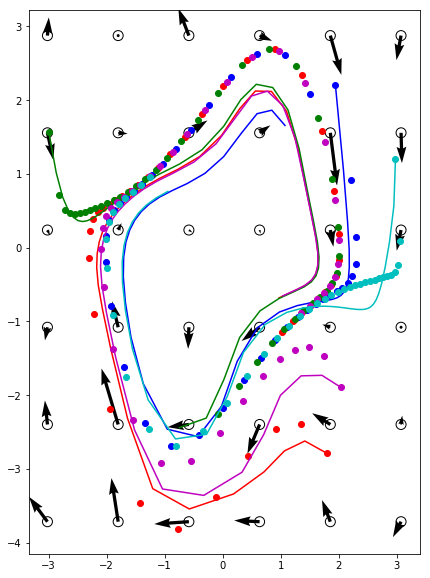

In [39]:
chain = sampler.samples
# print(chain[1])
# plotting
mean_U = np.mean([i[0][0][0] for i in chain if i[1]], axis=0)
# mean_U = chain[499][0][0]
print(mean_U)
kreg.U.data = torch.from_numpy(mean_U)
# mean_logsn = np.mean([i[0][0][1] for i in chain if i[1]], axis=0)
# kreg.logsn.data = torch.from_numpy(mean_logsn)
xode = odeint(kreg, x0, t).detach().numpy()
# U = kreg.U.detach().numpy()
U = mean_U
Z = kreg.Z.detach().numpy()
xode = np.transpose(xode,[1,0,2])

cols = ['r','b','g','m','c','k']
plt.figure(1,[7,10])
plt.scatter(Z[:,0],Z[:,1],100, facecolors='none', edgecolors='k')
plt.quiver(Z[:,0],Z[:,1],U[:,0],U[:,1],units='height',width=0.006,color='k')
for i in range(min(6,xode.shape[0])):
    plt.plot(X[i,:,0],X[i,:,1],'o',color=cols[i])
    plt.plot(xode[i,:,0],xode[i,:,1],'-',color=cols[i])

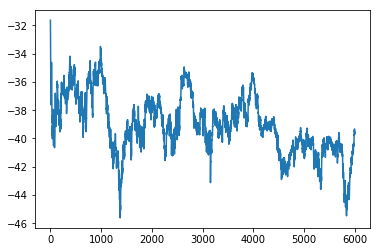

In [40]:
plt.plot(logp_array[:])

In [ ]:
# [sample[0][0][0][0][0] for sample in chain if sample[1]]
plt.plot([sample[0][0][0][10][1] for sample in chain[0:1000:10] if sample[1]])

In [ ]:
hess = hess_closure()